In [3]:
import os
import torch
import argparse
import torchvision
import numpy as np
from tqdm import tqdm
from contrastive import contrastive
from datetime import datetime
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from cifar10.model import ResNet18, ResNet34, ResNet50
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score

def to_np(x):
    return x.data.cpu().numpy()

def parsing():
    parser = argparse.ArgumentParser(description='Tunes a CIFAR Classifier with OE',
                                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--epochs', '-e', type=int, default=50,
                        help='Number of epochs to train.')
    parser.add_argument('--batch_size', '-b', type=int,
                        default=128, help='Batch size.')
    parser.add_argument('--seed', type=int, default=1,
                        help='seed for np(tinyimages80M sampling); 1|2|8|100|107')
    parser.add_argument('--num_workers', type=int, 
                        default=0, help='starting epoch from.')
    parser.add_argument('--start_epoch', type=int, 
                        default=0, help='starting epoch from.')
    parser.add_argument('--save_path', type=str, 
                        default=None, help='Path to save files.')
    parser.add_argument('--model_path', type=str, 
                        default=None, help='Path to model to resume training.')
    parser.add_argument('--config', type=str, 
                        default="normal", help='Config of data on training model.')
    parser.add_argument('--device', type=str, 
                        default="cuda", help='cuda or cpu.')
    # Optimizer Config
    parser.add_argument('--optimizer', type=str,
                        default='sgd', help='The initial learning rate.')
    parser.add_argument('--learning_rate', '-lr', type=float,
                        default=0.001, help='The initial learning rate.')
    parser.add_argument('--lr_update_rate', type=float,
                        default=5, help='The update rate for learning rate.')
    parser.add_argument('--lr_gamma', type=float,
                        default=0.9, help='The gamma param for updating learning rate.')
    parser.add_argument('--last_lr', type=float,
                        default=0, help='The gamma param for updating learning rate.')
                        
    parser.add_argument('--momentum', type=float, default=0.9, help='Momentum.')
    parser.add_argument('--decay', '-d', type=float,
                        default=0.0005, help='Weight decay (L2 penalty).')
    
    parser.add_argument('--noise', default='gaussian_noise', type=str, help='which noise to be run')
    parser.add_argument('--run_index', default=0, type=int, help='run index')
    
    args = parser.parse_args()

    return args

def load_model(args):

    # model = torchvision.models.resnet34()
    model = ResNet18(10)
    if args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), args.learning_rate, 
                                momentum=args.momentum,weight_decay=args.decay)
    elif args.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), args.learning_rate,
                                      weight_decay=args.decay)
    else:
        raise NotImplemented("Not implemented optimizer!")

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_update_rate, gamma=args.lr_gamma)
    criterion = torch.nn.CrossEntropyLoss().to(args.device)



    return model, criterion, optimizer, scheduler


def load_cifar10(cifar10_path):

    mean = [x / 255 for x in [125.3, 123.0, 113.9]]
    std = [x / 255 for x in [63.0, 62.1, 66.7]]

    train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

    train_data = torchvision.datasets.CIFAR10(
        cifar10_path, train=True, transform=train_transform, download=True)
    test_data = torchvision.datasets.CIFAR10(
        cifar10_path, train=False, transform=test_transform, download=True)

    return train_data, test_data



In [4]:
import sys
sys.argv = ['']

args = parsing()
torch.manual_seed(args.seed)
model, criterion, optimizer, scheduler = load_model(args)



cifar10_path = '/storage/users/makhavan/CSI/finals/datasets/data/'
train_dataset, test_dataset = load_cifar10(cifar10_path)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args.batch_size, num_workers=args.num_workers)
val_loader = DataLoader(test_dataset, shuffle=True, batch_size=args.batch_size, num_workers=args.num_workers)


if args.model_path is not None:
    save_path = args.save_path
    model_save_path = save_path + 'models/'
else:
    addr = datetime.today().strftime('%Y-%m-%d-%H-%M-%S-%f')
    save_path = f'./run/exp-' + addr + f"_({args.run_index}_{args.noise})_" + f'_{args.learning_rate}' + f'_{args.lr_update_rate}' + f'_{args.lr_gamma}' + f'_{args.optimizer}' + '/'
    model_save_path = save_path + 'models/'
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path, exist_ok=True)

writer = SummaryWriter(save_path)

train_global_iter = 0
global_eval_iter = 0
best_acc = 0.0
best_loss = np.inf
args.last_lr = args.learning_rate

Files already downloaded and verified
Files already downloaded and verified


In [6]:
model = model.to(args.device)
for inputs, targets in tqdm(train_loader):
    inputs , targets = inputs.to(args.device) , targets.to(args.device)

    optimizer.zero_grad()
    preds, features_list = model(inputs, True)
    break

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:10<?, ?it/s]


In [11]:
from contrastive import contrastive

In [15]:
features_list[-1][0].shape

torch.Size([512, 4, 4])

In [18]:
contrastive(features_list[-1][0:10], features_list[-1][0:5], features_list[-1][5:10])

RuntimeError: expand(torch.cuda.FloatTensor{[10, 512, 4, 4]}, size=[512, 4, 4]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

In [19]:
def norm(x):
    return torch.linalg.vector_norm(x)

def similarity(x, x_prime):
    return x * x_prime / (norm(x) * norm(x_prime))

In [27]:
x = features_list[-1][0]
positive = features_list[-1][1]
negative = features_list[-1][2]

In [28]:
similarity(x, positive)

tensor([[[0.0000e+00, 0.0000e+00, 1.1558e-04, 9.3301e-05],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9503e-05],
         [1.1187e-04, 5.2140e-05, 1.2582e-04, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9614e-05]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1894e-04],
         [0.0000e+00, 0.0000e+00, 2.2289e-04, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.1424e-04, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[4.8212e-05, 0.0000e+00, 5.3169e-05, 0.0000e+00],
         [1.3268e-06, 0.0000e+00, 0.0000e+00, 4.5922e-05],
         [0.0000e+00, 4.4529e-04, 1.0538e-04, 2.5481e-04],
         [3.7725e-05, 1.1454e-04, 6.1080e-06, 9.9965e-05]],

        ...,

        [[0.0000e+00, 0.0000e+00, 9.4053e-06, 0.0000e+00],
         [0.0000e+00, 3.8705e-06, 0.0000e+00, 1.4753e-07],
         [0.0000e+00, 1.7284e-05, 0.0000e+00, 4.8928e-04],
         [7.9244e-05, 9.4055e-05, 9.5484e-05, 8.5345e-05]],

        [[4.2654e-05, 2.9347e-04, 

In [46]:
def contrastive(input, positive, negative):
    epsilon = 1e-6 # for non getting devided by zero error
    sim_n = torch.zeros(negative.shape).to(negative.device)
    sim_p = torch.zeros(positive.shape).to(positive.device)
    if negative.shape[0] != input.shape[0]:
        for j, feature in enumerate(negative):
            sim_n[j] = similarity(input, feature)
    else:
        sim_n = similarity(input, negative)
    if positive.shape[0] != input.shape[0]:
        for j, feature in enumerate(positive):
            sim_p[j] = similarity(input, feature)
    else:
        sim_p = similarity(input, positive)
        
    denom = torch.cat([sim_n, sim_p]).to(negative.device) + epsilon # for non getting devided by zero error

    return (- 1/torch.abs(positive + epsilon)) * torch.log(torch.sum(torch.exp(sim_p), dim=0)/torch.sum(torch.exp(denom), dim=0))


In [47]:
contrastive(x, positive, negative)

tensor([[[6.9315e+05, 6.9314e+05, 4.9459e-01, 8.2410e-01],
         [6.9315e+05, 6.9315e+05, 6.9315e+05, 4.5643e+00],
         [3.1547e-01, 8.6553e-01, 3.6628e-01, 6.9314e+05],
         [6.9315e+05, 6.9315e+05, 6.9315e+05, 2.9905e-01]],

        [[6.9315e+05, 6.9314e+05, 1.4209e+00, 3.9976e-01],
         [6.9315e+05, 9.5192e-01, 1.0255e-01, 2.8783e-01],
         [3.6807e-01, 6.9315e+05, 2.0951e-01, 3.4772e-01],
         [6.9315e+05, 6.9315e+05, 3.1794e-01, 6.9315e+05]],

        [[7.0723e-01, 6.9314e+05, 7.7168e-01, 6.9315e+05],
         [2.9189e+01, 6.9315e+05, 1.7275e+02, 3.7885e-01],
         [6.9315e+05, 6.0817e-01, 1.3810e+00, 1.1992e-01],
         [1.6693e+00, 7.7338e-01, 1.8051e+01, 7.4694e-01]],

        ...,

        [[6.9315e+05, 6.9314e+05, 9.2950e-01, 6.9315e+05],
         [6.9315e+05, 1.0967e+01, 6.9315e+05, 7.7664e+01],
         [6.9315e+05, 6.4503e-01, 6.9315e+05, 1.1559e-01],
         [6.0296e-01, 5.3578e-01, 3.2183e-01, 3.4030e-01]],

        [[3.2173e-01, 2.4661e-01, 

In [2]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

cifar10_path = '/storage/users/makhavan/CSI/finals/datasets/data/'
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

train_data = torchvision.datasets.CIFAR10(
    cifar10_path, train=True, transform=train_transform, download=True)
test_data = torchvision.datasets.CIFAR10(
    cifar10_path, train=False, transform=test_transform, download=True)

train_loader = DataLoader(train_data, shuffle=False, batch_size=16)
test_loader = DataLoader(test_data, shuffle=False, batch_size=16)


Files already downloaded and verified
Files already downloaded and verified


In [52]:
import PIL
import torch
import numpy as np

class load_np_dataset(torch.utils.data.Dataset):
    def __init__(self, imgs_path, targets_path, transform):
        self.data = np.load(imgs_path)[:50000]
        self.targets = np.load(targets_path)[:50000]
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img , target = self.data[idx], self.targets[idx]
            
        img = PIL.Image.fromarray(img)
        img = self.transform(img)

        return img, target


In [53]:
noises = [
    'brightness',
    'color_jitter',
    'contrast',
    'defocus_blur',
    'elastic_transform',
    'flip',
    'fog',
    'gaussian_blur',
    'gaussian_noise',
    'glass_blur',
    'impulse_noise',
    'jpeg_compression',
    'motion_blur',
    'pixelate',
    'random_crop',
    'rot270',
    'rot90',
    'saturate',
    'shot_noise',
    'snow',
    'spatter',
    'speckle_noise',
    'zoom_blur',
]

np_train_target_path = '/storage/users/makhavan/CSI/finals/datasets/data_aug/CorCIFAR10_train/labels.npy'
np_test_target_path = '/storage/users/makhavan/CSI/finals/datasets/data_aug/CorCIFAR10_test/labels.npy'

np_train_root_path = '/storage/users/makhavan/CSI/finals/datasets/generalization_repo_dataset/CIFAR10_Train_AC/'
np_test_root_path = '/storage/users/makhavan/CSI/finals/datasets/generalization_repo_dataset/CIFAR10_Test_AC/'

train_dict = {}
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

for noise in noises:
    np_train_img_path = np_train_root_path + noise + '.npy'
    train_dict[noise] = load_np_dataset(np_train_img_path, np_train_target_path, train_transform)

test_dict = {}
transform = transforms.ToTensor()
for noise in noises:
    np_test_img_path = np_test_root_path + noise + '.npy'
    test_dict[noise] = load_np_dataset(np_test_img_path, np_test_target_path, test_transform)


In [54]:
len(train_dict['spatter']), len(train_data)

(50000, 50000)

In [5]:
loader_dict = {}
for noise in noises:
    loader_dict[noise] = DataLoader(train_dict[noise], shuffle=False, batch_size=16)

In [6]:
c = 0
for normal, fog in zip(train_loader, loader_dict['rot90']):
    if c > 2:
        break
    c += 1

In [7]:
img, label = normal
fog_img, fog_img_label = fog

In [8]:
label, fog_img_label

(tensor([2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2]),
 tensor([2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2], dtype=torch.uint8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


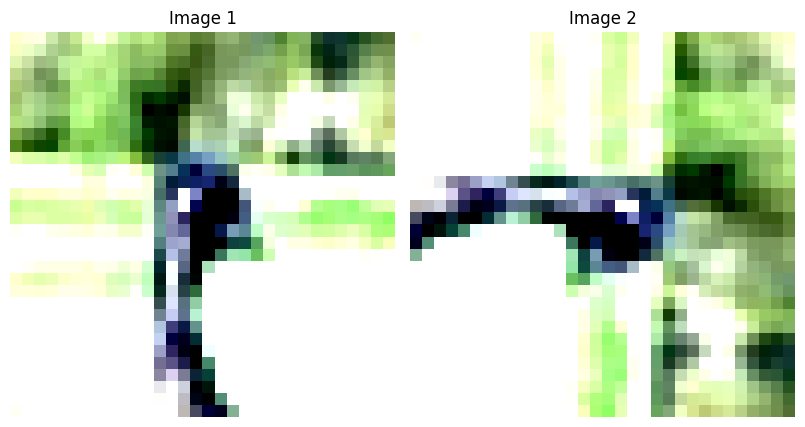

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed


# Display the first image
ax1.imshow(img[0].permute(1,2,0).detach().cpu().numpy())
ax1.set_title('Image 1')
ax1.axis('off')  # Turn off axes for cleaner presentation (optional)

# Display the second image
ax2.imshow(fog_img[0].permute(1,2,0).detach().cpu().numpy())
ax2.set_title('Image 2')
ax2.axis('off')  # Turn off axes (optional)

# Adjust spacing between subplots (optional)
plt.subplots_adjust(left=0.05, right=0.95, wspace=-0.2)

In [10]:
import pickle
with open('./clip_vec/softmax_sorted.pkl', 'rb') as file:
    probs = pickle.load(file)

In [11]:
list(probs[0].keys())[-1]

'spatter'

In [12]:
negetives = [loader_dict[list(probs[i].keys())[-1]] for i in range(10)]
positives = [loader_dict[list(probs[i].keys())[0]] for i in range(10)]

In [18]:
from cifar10.model import ResNet18, ResNet34, ResNet50
model = ResNet18(10)

In [38]:
def norm(x):
    return torch.linalg.vector_norm(x)

def similarity(x, x_prime):
    return x * x_prime / (norm(x) * norm(x_prime))

def contrastive(input, positive, negative, temperature=0.5, epsilon = 1e-9): # epsilon for non getting devided by zero error
    
    sim_n = torch.zeros(negative.shape).to(negative.device)
    sim_p = torch.zeros(positive.shape).to(positive.device)
    if negative.shape[0] != input.shape[0]:
        for j, feature in enumerate(negative):
            sim_n[j] = similarity(input, feature)
    else:
        sim_n = similarity(input, negative)
    if positive.shape[0] != input.shape[0]:
        for j, feature in enumerate(positive):
            sim_p[j] = similarity(input, feature)
    else:
        sim_p = similarity(input, positive)
        
    denom = torch.cat([sim_n, sim_p]).to(negative.device) + epsilon # for non getting devided by zero error

    return (- 1/torch.abs(positive + epsilon)) * torch.log(torch.sum(torch.exp(sim_p)/temperature, dim=0)/torch.sum(torch.exp(denom)/temperature, dim=0))


In [22]:
for normal, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, n0, n1, n2, n3, n4, n5, n6, n7, n8, n9 in zip(train_loader,
                       positives[0], positives[1], positives[2], positives[3], positives[4],
                       positives[5], positives[6], positives[7], positives[8], positives[9],
                       negetives[0], negetives[1], negetives[2], negetives[3], negetives[4],
                       negetives[5], negetives[6], negetives[7], negetives[8], negetives[9]):
    ps = [p0[0], p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0]]
    ns = [n0[0], n1[0], n2[0], n3[0], n4[0], n5[0], n6[0], n7[0], n8[0], n9[0]]
    
    imgs, labels = normal
    positive_imgs = torch.zeros_like(imgs)
    negative_imgs = torch.zeros_like(imgs)
    for i, label in enumerate(labels):
        positive_imgs[i] = ps[label][i]
        negative_imgs[i] = ns[label][i]
        # positive_imgs, negative_imgs = np.asarray(positive_imgs), np.asarray(negative_imgs)
    pred, normal_features = model(imgs, True)
    positive_pred, positive_features = model(positive_imgs, True)
    negative_pred, negative_features = model(negative_imgs, True)
    
    break

In [43]:
len(positives[0])

15625

In [30]:
normal_features[-1][0].shape, positive_features[-1][0].shape, negative_features[-1][0].shape

(torch.Size([512, 4, 4]), torch.Size([512, 4, 4]), torch.Size([512, 4, 4]))

In [40]:
cc_loss = 0
for norm_f, pos_f, neg_f in zip(normal_features[-1], positive_features[-1], negative_features[-1]):
    cc_loss += torch.sum(contrastive(norm_f, pos_f, neg_f))

In [41]:
cc_loss

tensor(3.1651e+13, grad_fn=<AddBackward0>)

In [14]:
labels

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


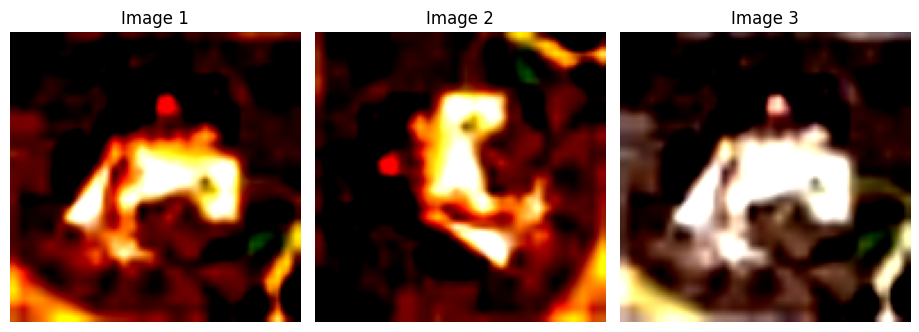

In [17]:
import matplotlib.pyplot as plt
import cv2
idx=0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

# Display the first image
ax1.imshow(cv2.resize(imgs[idx].permute(1,2,0).detach().cpu().numpy(), (128, 128)))
ax1.set_title('Image 1')
ax1.axis('off')  # Turn off axes for cleaner presentation (optional)

# Display the second image
ax2.imshow(cv2.resize(positive_imgs[idx].permute(1,2,0).detach().cpu().numpy(), (128, 128)))
ax2.set_title('Image 2')
ax2.axis('off')  # Turn off axes (optional)

ax3.imshow(cv2.resize(negative_imgs[idx].permute(1,2,0).detach().cpu().numpy(), (128, 128)))
ax3.set_title('Image 3')
ax3.axis('off')  # Turn off axes (optional)

# Adjust spacing between subplots (optional)
plt.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

In [1]:
import os
import torch
import argparse
import torchvision
import numpy as np
from tqdm import tqdm
from contrastive import contrastive
from datetime import datetime
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from cifar10.model import ResNet18, ResNet34, ResNet50
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score

def to_np(x):
    return x.data.cpu().numpy()

def parsing():
    parser = argparse.ArgumentParser(description='Tunes a CIFAR Classifier with OE',
                                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--epochs', '-e', type=int, default=50,
                        help='Number of epochs to train.')
    parser.add_argument('--batch_size', '-b', type=int,
                        default=128, help='Batch size.')
    parser.add_argument('--seed', type=int, default=1,
                        help='seed for np(tinyimages80M sampling); 1|2|8|100|107')
    parser.add_argument('--num_workers', type=int, 
                        default=0, help='starting epoch from.')
    parser.add_argument('--start_epoch', type=int, 
                        default=0, help='starting epoch from.')
    parser.add_argument('--save_path', type=str, 
                        default=None, help='Path to save files.')
    parser.add_argument('--model_path', type=str, 
                        default=None, help='Path to model to resume training.')
    parser.add_argument('--config', type=str, 
                        default="normal", help='Config of data on training model.')
    parser.add_argument('--device', type=str, 
                        default="cuda", help='cuda or cpu.')
    # Optimizer Config
    parser.add_argument('--optimizer', type=str,
                        default='sgd', help='The initial learning rate.')
    parser.add_argument('--learning_rate', '-lr', type=float,
                        default=0.001, help='The initial learning rate.')
    parser.add_argument('--lr_update_rate', type=float,
                        default=5, help='The update rate for learning rate.')
    parser.add_argument('--lr_gamma', type=float,
                        default=0.9, help='The gamma param for updating learning rate.')
    parser.add_argument('--last_lr', type=float,
                        default=0, help='The gamma param for updating learning rate.')
                        
    parser.add_argument('--momentum', type=float, default=0.9, help='Momentum.')
    parser.add_argument('--decay', '-d', type=float,
                        default=0.0005, help='Weight decay (L2 penalty).')
    
    parser.add_argument('--noise', default='gaussian_noise', type=str, help='which noise to be run')
    parser.add_argument('--run_index', default=0, type=int, help='run index')
    
    args = parser.parse_args()

    return args


def train(train_loader, positives, negetives, net, train_global_iter, criterion, optimizer, device, writer):

    print("Traning...")
    net = net.to(device)
    net.train()  # enter train mode

    # track train classification accuracy
    epoch_accuracies = {
        'normal': [],
        'positive': [],
        'negative': []
    }
    epoch_loss = {
        'loss': [],
        'ce': [],
        'contrastive': []
    }
    for normal, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, n0, n1, n2, n3, n4, n5, n6, n7, n8, n9 in zip(train_loader,
                       positives[0], positives[1], positives[2], positives[3], positives[4],
                       positives[5], positives[6], positives[7], positives[8], positives[9],
                       negetives[0], negetives[1], negetives[2], negetives[3], negetives[4],
                       negetives[5], negetives[6], negetives[7], negetives[8], negetives[9]):
        ps = [p0[0], p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0]]
        ns = [n0[0], n1[0], n2[0], n3[0], n4[0], n5[0], n6[0], n7[0], n8[0], n9[0]]
        
        imgs, labels = normal
        imgs, labels = imgs.to(args.device), labels.to(args.device)
        positive_imgs = torch.zeros_like(imgs)
        negative_imgs = torch.zeros_like(imgs)
        for i, label in enumerate(labels):
            positive_imgs[i] = ps[label][i].to(args.device)
            negative_imgs[i] = ns[label][i].to(args.device)
            # positive_imgs, negative_imgs = np.asarray(positive_imgs), np.asarray(negative_imgs)

        positive_imgs, negative_imgs = positive_imgs.to(args.device), negative_imgs.to(args.device)

        optimizer.zero_grad()
        preds, normal_features = model(imgs, True)
        positive_preds, positive_features = model(positive_imgs, True)
        negative_preds, negative_features = model(negative_imgs, True)

        normal_probs = torch.softmax(preds, dim=1)
        positive_probs = torch.softmax(positive_preds, dim=1)
        negative_probs = torch.softmax(negative_preds, dim=1)

        # Calculate loss contrastive for layer
        loss_contrastive = 0
        for norm_f, pos_f, neg_f in zip(normal_features[-1], positive_features[-1], negative_features[-1]):
            loss_contrastive = loss_contrastive + torch.sum(contrastive(norm_f, pos_f, neg_f))

        loss_ce = criterion(preds, labels)
        loss = loss_ce + loss_contrastive

        normal_output_index = torch.argmax(normal_probs, dim=1)
        positive_output_index = torch.argmax(positive_probs, dim=1)
        negative_output_index = torch.argmax(negative_probs, dim=1)
        acc_normal = accuracy_score(list(to_np(normal_output_index)), list(to_np(labels)))
        acc_positive = accuracy_score(list(to_np(positive_output_index)), list(to_np(labels)))
        acc_negative = accuracy_score(list(to_np(negative_output_index)), list(to_np(labels)))

        # Logging section
        epoch_accuracies['normal'].append(acc_normal)
        epoch_accuracies['positive'].append(acc_positive)
        epoch_accuracies['negative'].append(acc_negative)
        epoch_loss['loss'].append(loss)
        epoch_loss['ce'].append(loss_ce)
        epoch_loss['contrastive'].append(loss_contrastive)

        train_global_iter += 1
        writer.add_scalar("Train/loss", loss, train_global_iter)
        writer.add_scalar("Train/loss_ce", loss_ce.item(), train_global_iter)
        writer.add_scalar("Train/loss_contrastive", loss_contrastive, train_global_iter)
        writer.add_scalar("Train/acc_normal", acc_normal, train_global_iter)
        writer.add_scalar("Train/acc_positive", acc_positive, train_global_iter)
        writer.add_scalar("Train/acc_negative", acc_negative, train_global_iter)

        loss.backward()
        optimizer.step()

    return train_global_iter, epoch_loss, epoch_accuracies 


def test(eval_loader, positives, negetives, net, global_eval_iter, criterion, device, writer):

    print("Evaluating...")
    net = net.to(device)
    net.eval()  # enter train mode

    # track train classification accuracy
    epoch_accuracies = {
        'normal': [],
        'positive': [],
        'negative': []
    }
    epoch_loss = {
        'loss': [],
        'ce': [],
        'contrastive': []
    }
    with torch.no_grad():
        for normal, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, n0, n1, n2, n3, n4, n5, n6, n7, n8, n9 in zip(eval_loader,
                       positives[0], positives[1], positives[2], positives[3], positives[4],
                       positives[5], positives[6], positives[7], positives[8], positives[9],
                       negetives[0], negetives[1], negetives[2], negetives[3], negetives[4],
                       negetives[5], negetives[6], negetives[7], negetives[8], negetives[9]):
            ps = [p0[0], p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0]]
            ns = [n0[0], n1[0], n2[0], n3[0], n4[0], n5[0], n6[0], n7[0], n8[0], n9[0]]
            
            imgs, labels = normal
            imgs, labels = imgs.to(args.device), labels.to(args.device)
            positive_imgs = torch.zeros_like(imgs)
            negative_imgs = torch.zeros_like(imgs)
            for i, label in enumerate(labels):
                positive_imgs[i] = ps[label][i].to(args.device)
                negative_imgs[i] = ns[label][i].to(args.device)
                # positive_imgs, negative_imgs = np.asarray(positive_imgs), np.asarray(negative_imgs)

            positive_imgs, negative_imgs = positive_imgs.to(args.device), negative_imgs.to(args.device)

            preds, normal_features = model(imgs, True)
            positive_preds, positive_features = model(positive_imgs, True)
            negative_preds, negative_features = model(negative_imgs, True)

            normal_probs = torch.softmax(preds, dim=1)
            positive_probs = torch.softmax(positive_preds, dim=1)
            negative_probs = torch.softmax(negative_preds, dim=1)

            # Calculate loss contrastive for layer
            loss_contrastive = 0
            for norm_f, pos_f, neg_f in zip(normal_features[-1], positive_features[-1], negative_features[-1]):
                loss_contrastive = loss_contrastive + torch.sum(contrastive(norm_f, pos_f, neg_f))

            loss_ce = criterion(preds, labels)
            loss = loss_ce + loss_contrastive

            normal_output_index = torch.argmax(normal_probs, dim=1)
            positive_output_index = torch.argmax(positive_probs, dim=1)
            negative_output_index = torch.argmax(negative_probs, dim=1)
            acc_normal = accuracy_score(list(to_np(normal_output_index)), list(to_np(labels)))
            acc_positive = accuracy_score(list(to_np(positive_output_index)), list(to_np(labels)))
            acc_negative = accuracy_score(list(to_np(negative_output_index)), list(to_np(labels)))

            # Logging section
            epoch_accuracies['normal'].append(acc_normal)
            epoch_accuracies['positive'].append(acc_positive)
            epoch_accuracies['negative'].append(acc_negative)
            epoch_loss['loss'].append(loss)
            epoch_loss['ce'].append(loss_ce)
            epoch_loss['contrastive'].append(loss_contrastive)

            global_eval_iter += 1
            writer.add_scalar("Evaluation/loss", loss, global_eval_iter)
            writer.add_scalar("Evaluation/loss_ce", loss_ce.item(), global_eval_iter)
            writer.add_scalar("Evaluation/loss_contrastive", loss_contrastive, global_eval_iter)
            writer.add_scalar("Evaluation/acc_normal", acc_normal, global_eval_iter)
            writer.add_scalar("Evaluation/acc_positive", acc_positive, global_eval_iter)
            writer.add_scalar("Evaluation/acc_negative", acc_negative, global_eval_iter)


    return global_eval_iter, epoch_loss, epoch_accuracies


def load_model(args):

    # model = torchvision.models.resnet34()
    model = ResNet18(10)
    if args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), args.learning_rate, 
                                momentum=args.momentum,weight_decay=args.decay)
    elif args.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), args.learning_rate,
                                      weight_decay=args.decay)
    else:
        raise NotImplemented("Not implemented optimizer!")

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_update_rate, gamma=args.lr_gamma)
    criterion = torch.nn.CrossEntropyLoss().to(args.device)



    return model, criterion, optimizer, scheduler


def load_cifar10(cifar10_path):

    mean = [x / 255 for x in [125.3, 123.0, 113.9]]
    std = [x / 255 for x in [63.0, 62.1, 66.7]]

    train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

    train_data = torchvision.datasets.CIFAR10(
        cifar10_path, train=True, transform=train_transform, download=True)
    test_data = torchvision.datasets.CIFAR10(
        cifar10_path, train=False, transform=test_transform, download=True)

    return train_data, test_data

import PIL
import torch
import numpy as np

class load_np_dataset(torch.utils.data.Dataset):
    def __init__(self, imgs_path, targets_path, transform, train=True):
        if train:
            self.data = np.load(imgs_path)[:50000]
            self.targets = np.load(targets_path)[:50000]
        else:
            self.data = np.load(imgs_path)[:10000]
            self.targets = np.load(targets_path)[:10000]
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img , target = self.data[idx], self.targets[idx]
            
        img = PIL.Image.fromarray(img)
        img = self.transform(img)

        return img, target


def noise_loader(args):
    noises = [
    'brightness',
    'color_jitter',
    'contrast',
    'defocus_blur',
    'elastic_transform',
    'flip',
    'fog',
    'gaussian_blur',
    'gaussian_noise',
    'glass_blur',
    'impulse_noise',
    'jpeg_compression',
    'motion_blur',
    'pixelate',
    'random_crop',
    'rot270',
    'rot90',
    'saturate',
    'shot_noise',
    'snow',
    'spatter',
    'speckle_noise',
    'zoom_blur',
    ]

    np_train_target_path = '/storage/users/makhavan/CSI/finals/datasets/data_aug/CorCIFAR10_train/labels.npy'
    np_test_target_path = '/storage/users/makhavan/CSI/finals/datasets/data_aug/CorCIFAR10_test/labels.npy'

    np_train_root_path = '/storage/users/makhavan/CSI/finals/datasets/generalization_repo_dataset/CIFAR10_Train_AC/'
    np_test_root_path = '/storage/users/makhavan/CSI/finals/datasets/generalization_repo_dataset/CIFAR10_Test_AC/'

    train_dict = {}
    mean = [x / 255 for x in [125.3, 123.0, 113.9]]
    std = [x / 255 for x in [63.0, 62.1, 66.7]]

    train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

    for noise in noises:
        np_train_img_path = np_train_root_path + noise + '.npy'
        train_dict[noise] = load_np_dataset(np_train_img_path, np_train_target_path, train_transform, train=True)

    test_dict = {}
    for noise in noises:
        np_test_img_path = np_test_root_path + noise + '.npy'
        test_dict[noise] = load_np_dataset(np_test_img_path, np_test_target_path, test_transform, train=False)

    train_loader_dict = {}
    for noise in noises:
        train_loader_dict[noise] = DataLoader(train_dict[noise], shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers)
    
    test_loader_dict = {}
    for noise in noises:
        test_loader_dict[noise] = DataLoader(test_dict[noise], shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers)

    return train_loader_dict, test_loader_dict

import sys

sys.argv = ['']

args = parsing()
torch.manual_seed(args.seed)
model, criterion, optimizer, scheduler = load_model(args)



cifar10_path = '/storage/users/makhavan/CSI/finals/datasets/data/'
train_dataset, test_dataset = load_cifar10(cifar10_path)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers)
val_loader = DataLoader(test_dataset, shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers)

print("Start Loading noises")
train_loader_dict, test_loader_dict = noise_loader(args)
print("Loading noises finished!")


import pickle
with open('./clip_vec/softmax_sorted.pkl', 'rb') as file:
    clip_probs = pickle.load(file)

print("Creating noises loader")
train_positives = [train_loader_dict[list(clip_probs[i].keys())[0]] for i in range(10)]
train_negetives = [train_loader_dict[list(clip_probs[i].keys())[-1]] for i in range(10)]

test_positives = [test_loader_dict[list(clip_probs[i].keys())[0]] for i in range(10)]
test_negetives = [test_loader_dict[list(clip_probs[i].keys())[-1]] for i in range(10)]
print("Noises loader created!")


train_global_iter = 0
global_eval_iter = 0
best_acc = 0.0
best_loss = np.inf
args.last_lr = args.learning_rate


Files already downloaded and verified
Files already downloaded and verified
Start Loading noises
Loading noises finished!
Creating noises loader
Noises loader created!


In [3]:
positives, negetives = train_positives, train_negetives
print("Traning...")
model = model.to(args.device)
model.train()  # enter train mode

# track train classification accuracy
epoch_accuracies = {
    'normal': [],
    'positive': [],
    'negative': []
}
epoch_loss = {
    'loss': [],
    'ce': [],
    'contrastive': []
}
for normal, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, n0, n1, n2, n3, n4, n5, n6, n7, n8, n9 in zip(train_loader,
                    positives[0], positives[1], positives[2], positives[3], positives[4],
                    positives[5], positives[6], positives[7], positives[8], positives[9],
                    negetives[0], negetives[1], negetives[2], negetives[3], negetives[4],
                    negetives[5], negetives[6], negetives[7], negetives[8], negetives[9]):
    ps = [p0[0], p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0]]
    ns = [n0[0], n1[0], n2[0], n3[0], n4[0], n5[0], n6[0], n7[0], n8[0], n9[0]]
    
    imgs, labels = normal
    imgs, labels = imgs.to(args.device), labels.to(args.device)
    positive_imgs = torch.zeros_like(imgs)
    negative_imgs = torch.zeros_like(imgs)
    for i, label in enumerate(labels):
        positive_imgs[i] = ps[label][i].to(args.device)
        negative_imgs[i] = ns[label][i].to(args.device)
        # positive_imgs, negative_imgs = np.asarray(positive_imgs), np.asarray(negative_imgs)

    positive_imgs, negative_imgs = positive_imgs.to(args.device), negative_imgs.to(args.device)

    optimizer.zero_grad()
    preds, normal_features = model(imgs, True)
    positive_preds, positive_features = model(positive_imgs, True)
    negative_preds, negative_features = model(negative_imgs, True)

    normal_probs = torch.softmax(preds, dim=1)
    positive_probs = torch.softmax(positive_preds, dim=1)
    negative_probs = torch.softmax(negative_preds, dim=1)

    # Calculate loss contrastive for layer
    loss_contrastive = 0
    for norm_f, pos_f, neg_f in zip(normal_features[-1], positive_features[-1], negative_features[-1]):
        loss_contrastive = loss_contrastive + torch.sum(contrastive(norm_f, pos_f, neg_f))

    loss_ce = criterion(preds, labels)
    loss = loss_ce + loss_contrastive

    normal_output_index = torch.argmax(normal_probs, dim=1)
    positive_output_index = torch.argmax(positive_probs, dim=1)
    negative_output_index = torch.argmax(negative_probs, dim=1)
    acc_normal = accuracy_score(list(to_np(normal_output_index)), list(to_np(labels)))
    acc_positive = accuracy_score(list(to_np(positive_output_index)), list(to_np(labels)))
    acc_negative = accuracy_score(list(to_np(negative_output_index)), list(to_np(labels)))

    # Logging section
    epoch_accuracies['normal'].append(acc_normal)
    epoch_accuracies['positive'].append(acc_positive)
    epoch_accuracies['negative'].append(acc_negative)
    epoch_loss['loss'].append(loss)
    epoch_loss['ce'].append(loss_ce)
    epoch_loss['contrastive'].append(loss_contrastive)

    train_global_iter += 1
    break

Traning...


In [30]:
labels

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1,
        2, 2, 9, 2, 6, 6, 1, 9], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


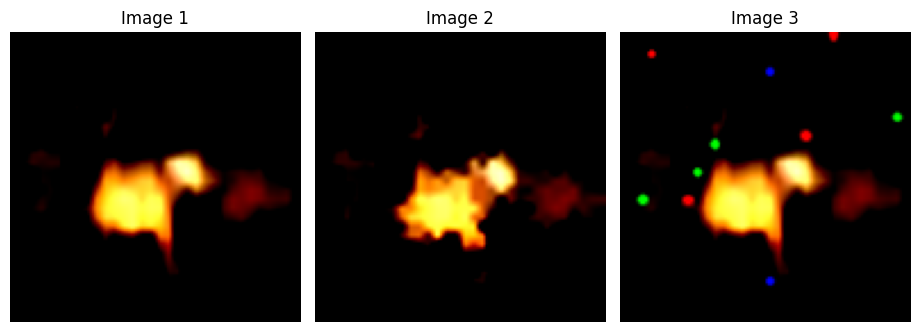

In [33]:
import matplotlib.pyplot as plt
import cv2
idx=3
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

# Display the first image
ax1.imshow(cv2.resize(imgs[idx].permute(1,2,0).detach().cpu().numpy(), (128, 128)))
ax1.set_title('Image 1')
ax1.axis('off')  # Turn off axes for cleaner presentation (optional)

# Display the second image
ax2.imshow(cv2.resize(positive_imgs[idx].permute(1,2,0).detach().cpu().numpy(), (128, 128)))
ax2.set_title('Image 2')
ax2.axis('off')  # Turn off axes (optional)

ax3.imshow(cv2.resize(negative_imgs[idx].permute(1,2,0).detach().cpu().numpy(), (128, 128)))
ax3.set_title('Image 3')
ax3.axis('off')  # Turn off axes (optional)

# Adjust spacing between subplots (optional)
plt.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

In [46]:
def norm(x):
    return torch.linalg.vector_norm(x)

def similarity(x, x_prime):
    return x * x_prime / (norm(x) * norm(x_prime))

def cosine_similarity(feat_map1, feat_map2):
  # Flatten the feature maps into vectors
  feat_map1_vec = feat_map1.flatten()
  feat_map2_vec = feat_map2.flatten()

  # Calculate dot product and norms
  dot_product = torch.dot(feat_map1_vec, feat_map2_vec)
  norm1 = torch.linalg.norm(feat_map1_vec, ord=1)
  norm2 = torch.linalg.norm(feat_map2_vec, ord=1)

  # Prevent division by zero
  if norm1 == 0 or norm2 == 0:
    return 0

  cosine_sim = dot_product / (norm1 * norm2)
  return cosine_sim


def contrastive(input, positive, negative, temperature=0.5, epsilon = 1e-9): # epsilon for non getting devided by zero error
    
    sim_n = torch.zeros(negative.shape).to(negative.device)
    sim_p = torch.zeros(positive.shape).to(positive.device)
    if negative.shape[0] != input.shape[0]:
        for j, feature in enumerate(negative):
            sim_n[j] = similarity(input, feature)
    else:
        # sim_n = similarity(input, negative)
        sim_n = cosine_similarity(input, negative)
        
    if positive.shape[0] != input.shape[0]:
        for j, feature in enumerate(positive):
            sim_p[j] = similarity(input, feature)
    else:
        # sim_p = similarity(input, positive)
        sim_p = cosine_similarity(input, positive)
        
    denom = sim_n + sim_p#).to(negative.device) + epsilon # for non getting devided by zero error

    card = positive.shape[0] * positive.shape[1] * positive.shape[2]
    return (- 1/card) * torch.log(torch.sum(torch.exp(sim_p)/temperature, dim=0)/torch.sum(torch.exp(denom)/temperature, dim=0))


In [48]:
norm_f, pos_f, neg_f = normal_features[-1][1], positive_features[-1][1], negative_features[-1][1]

In [49]:
sim_n = torch.zeros(neg_f.shape).to(neg_f.device)
sim_p = torch.zeros(pos_f.shape).to(pos_f.device)

sim_n = cosine_similarity(norm_f, neg_f)
sim_p = cosine_similarity(norm_f, pos_f)


In [50]:
sim_n, sim_p

(tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>))

In [51]:
contrastive(norm_f, pos_f, neg_f)

tensor(1.9494e-08, device='cuda:0', grad_fn=<MulBackward0>)

In [53]:
np.mean(epoch_loss['loss'])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.